In [1]:
import pandas as pd
# data = pd.read_csv("/Users/esmondchu/Dropbox/UC_Davis/STAT/STA141CSpring18/Final_Project/word2vec/fixed_data/training.csv", \
#                   header=None)
data = pd.read_csv("/Users/esmondchu/Dropbox/UC_Davis/STAT/STA141CSpring18/Final_Project/train.csv")

In [2]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
data.shape

(404290, 6)

# Preprocessing

In [4]:
def string_process(str_in):
    """
    Change a sentence in to lowercase and remove punctuation
    :param str_in (str): the process sentence
    :return: str: the processed sentence
    """
    punc = '?,!.()\'":'
    str_out = str_in.lower()
    for i in punc:
        str_out = str_out.replace(i, " ")
    return str_out

# Overlapping Score

In [5]:
data_question = data[['question1','question2','is_duplicate']]
# data_question = data[[3,4,5]]
# data_question.columns = ['question1','question2','is_duplicate']

## Handle Problematic Rows

In [6]:
#find problematic rows
drop_rows = []
for i in range(len(data_question.question2)):
    if type(data_question.question2[i]) == float:
        drop_rows.append(i)

In [7]:
for i in range(len(data_question.question1)):
    if type(data_question.question1[i]) == float:
        drop_rows.append(i)

In [8]:
#create a new copy for modification
new_data_df = data_question.copy()

In [9]:
#drop problematic rows
new_data_df.drop(new_data_df.index[drop_rows], inplace=True)

## Calculate Overlapping Score

In [10]:
new_data_df.question1 = new_data_df.question1.apply(string_process)
new_data_df.question2 = new_data_df.question2.apply(string_process)

In [11]:
#split words in a sentence
que1 = [i.split() for i in new_data_df.question1]
que2 = [i.split() for i in new_data_df.question2]

# que1 = list(data_question.question1)
# que2 = list(data_question.question2)

In [12]:
overlap_score = []
for q1, q2 in zip(que1,que2):
    score1 = 0
    score2 = 0
    for i in q1:
        if i in q2:
            score1 += 1
    for i in q2:
        if i in q1:
            score2 += 1

    overlapping = (score1 + score2)/(len(q1) + len(q2))
    overlap_score.append(overlapping)

In [13]:
new_data_df['overlapping_score'] = pd.Series(overlap_score)

In [14]:
new_data_df.head()

,question1,question2,is_duplicate,overlapping_score
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.961538
1,what is the story of kohinoor koh-i-noor dia...,what would happen if the indian government sto...,0,0.523810
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.333333
3,why am i mentally very lonely how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,0.000000
4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.400000


# Training Accuracy

In [15]:
import numpy as np

$\text{sign}(\text{overlapping score}(q1,q2)-\text{thr})$

In [16]:
# def cal_accuracy(thr):
#     sig_function = lambda x, thr: np.sign(x - thr)
#     predicted = [sig_function(i, thr) for i in overlap_score]

#     correct = 0
#     for i,j in zip(new_data_df.is_duplicate, predicted):
#         if i == j or (i == 0 and j == -1):
#             correct += 1
        
#     accuracy = correct/len(predicted)
#     return accuracy 

In [17]:
# def cal_accuracy(thr):
#     predicted = list(((np.array(overlap_score) - thr)>0)*1)
#     correct = 0
#     for i, j in zip(new_data_df.is_duplicate, predicted):
#         if i == j:
#             correct += 1
    
#     accuracy = correct/len(predicted)
#     return accuracy

In [18]:
def cal_accuracy(thr):
    predicted = list(((np.array(overlap_score) - thr) > 0) * 1)
    accuracy = np.sum(predicted == new_data_df.is_duplicate)/len(predicted)
    return accuracy

In [19]:
import time

In [20]:
start = time.time()
accuracy_thr = [cal_accuracy(i) for i in list(np.arange(0,1,0.1))]
end = time.time()
print('Run Time:', end-start)

Run Time: 0.5359454154968262


In [21]:
display_df = pd.DataFrame({'Accuracy': accuracy_thr, 'Threshold':list(np.arange(0,1,0.1))})
display_df

,Accuracy,Threshold
0,0.411193,0.0
1,0.438587,0.1
2,0.505938,0.2
3,0.577624,0.3
4,0.639390,0.4
5,0.664837,0.5
6,0.659687,0.6
7,0.645321,0.7
8,0.630943,0.8
9,0.625798,0.9


In [22]:
import matplotlib.pyplot as plt

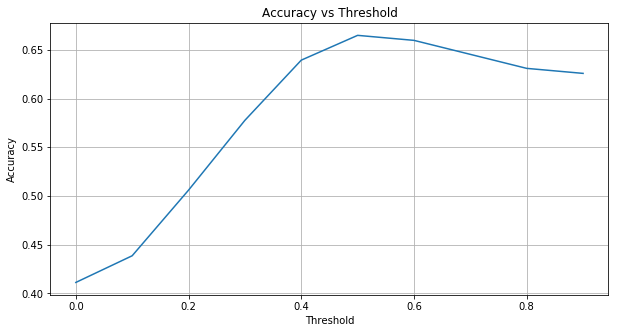

In [23]:
x = list(np.arange(0,1,0.1))
plt.figure(figsize=(10,5))
plt.plot(x, accuracy_thr)
plt.title('Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

# Using word2vec to advance overlapping score

In [24]:
import gensim 
import logging
import time

In [25]:
#build sentence base, question 1 combines with question 2
que = que1 + que2

In [26]:
#build model from question 1 and question 2
start = time.time()
model = gensim.models.Word2Vec(que, size=100, window=5, min_count=5, workers=4)
end = time.time()
print('Run Time:', end-start)

Run Time: 25.86111617088318


In [27]:
#example
model.most_similar(positive=['korea'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('carolina', 0.7837440371513367),
 ('africa', 0.7551262974739075),
 ('america', 0.714587926864624),
 ('dakota', 0.7018466591835022),
 ('sudan', 0.656804621219635),
 ('vietnam', 0.65174400806427),
 ('koreans', 0.6452322602272034),
 ('pole', 0.641333818435669),
 ('china', 0.6400418877601624),
 ('japan', 0.6388459205627441)]

## Add constrain from built model for calculating overlapping score 

In [28]:
from progressbar import ProgressBar
bar = ProgressBar()

In [29]:
similarity_rate = 0.1
top_pick_num = 10

overlap_score_model = []
for q1, q2 in bar(zip(que1[0:100],que2[0:100])):
    score1 = 0
    score2 = 0
    #handle score 1
    for i in q1:
        try:
            check_list_q1 = model.most_similar(positive=[i])
            picked_q1 = [i[0] for i in check_list_q1 if i[1] >= similarity_rate]
            if len(picked_q1) <= top_pick_num:
                selected_q1 = picked_q1
            else:
                selected_q1 = picked_q1[0:top_pick_num]
            for i in selected_q1:
                if i in q2:
                    score1 += 1
        except:
            score1 = 0
    #handle score 2
    for i in q2:
        try:
            check_list_q2 = model.most_similar(positive=[i])
            picked_q2 = [i[0] for i in check_list_q2 if i[1] >= similarity_rate]
            if len(picked_q2) <= top_pick_num:
                selected_q2 = picked_q2
            else:
                selected_q2 = picked_q2[0:top_pick_num]
            for i in selected_q2:
                if i in q1:
                    score2 += 1
        except:
            score2 = 0
    
    overlapping_model = (score1 + score2)/(len(q1) + len(q2))
    overlap_score_model.append(overlapping_model)

/ |#                                                  | 0 Elapsed Time: 0:00:00/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
| |                            #                     | 99 Elapsed Time: 0:00:02


In [30]:
def cal_accuracy_model(thr):
    predicted_model = list(((np.array(overlap_score_model) - thr) > 0) * 1)
    accuracy_model = np.sum(predicted_model == new_data_df.is_duplicate[0:100])/len(predicted_model)
    return accuracy_model

In [31]:
start = time.time()
accuracy_thr_model = [cal_accuracy_model(i) for i in list(np.arange(0,1,0.1))]
end = time.time()
print('Run Time:', end-start)

Run Time: 0.006186962127685547


In [32]:
accuracy_thr_model

[0.45000000000000001,
 0.5,
 0.63,
 0.60999999999999999,
 0.63,
 0.64000000000000001,
 0.65000000000000002,
 0.67000000000000004,
 0.64000000000000001,
 0.64000000000000001]

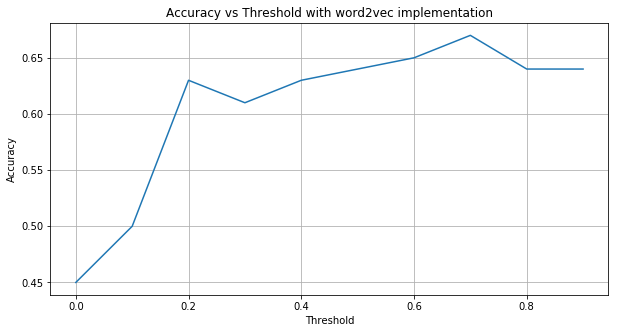

In [33]:
x = list(np.arange(0,1,0.1))
plt.figure(figsize=(10,5))
plt.plot(x, accuracy_thr_model)
plt.title('Accuracy vs Threshold with word2vec implementation')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [36]:
print('Best accuracy we got with threshold 0.7 is', cal_accuracy_model(0.7), '.')

Best accuracy we got with threshold 0.7 is 0.67 .
